In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pymc import MCMC
import seaborn
import corner
import numpy as np
from parmed.topologyobjects import DihedralType

In [2]:
from torsionfit.toy_model import ToyModel

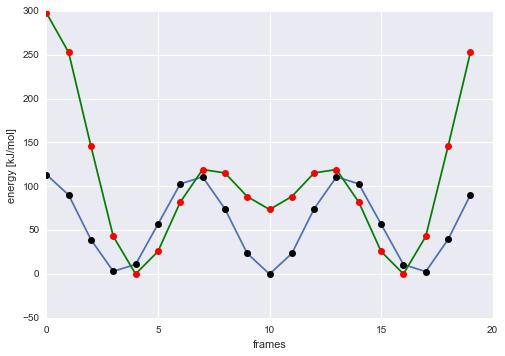

In [3]:
#toy = ToyModel(true_value=DihedralType(10, 1, 180.0, 1, 1), initial_value=DihedralType(1, 1, 0, 1, 1),continuous=True, 
               #n_increments=15)
             #decouple_n=True)
toy = ToyModel(n_increments=20, continuous=True)
#toy.scan_set.save_initial_mm(toy._param)
plt.plot(toy.synthetic_energy)
plt.plot(toy.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.plot(toy.scan_set.mm_energy, color='g')
plt.plot(toy.scan_set.initial_mm, 'ko', color='r')

In [4]:
# sample
sampler = MCMC(toy.model.pymc_parameters)
sampler.sample(iter=1000)

 [-----------------100%-----------------] 1000 of 1000 complete in 22.9 sec

In [5]:
print('true value')
print(toy.true_value)
print('initial value')
print(toy.initial_value)

true value
<DihedralTypes [<DihedralType; phi_k=13.559, per=6, phase=0.000,  scee=1.000, scnb=1.000>]>
initial value
<DihedralTypes [<DihedralType; phi_k=19.132, per=4, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=10.657, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=16.162, per=6, phase=0.000,  scee=1.000, scnb=1.000>]>


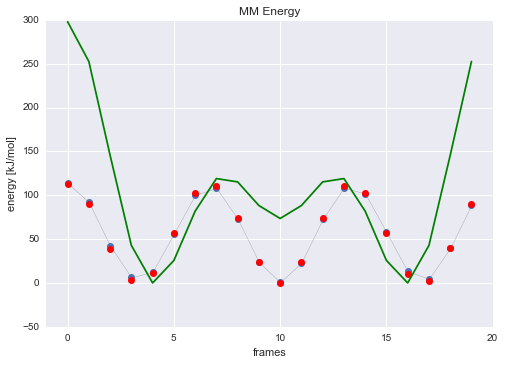

In [6]:
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False)
plt.plot(toy.synthetic_energy, 'o', color='r')
plt.title('MM Energy')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
#plt.plot(sampler.trace('mm_energy')[0])
plt.plot(toy.scan_set.initial_mm, color='g')

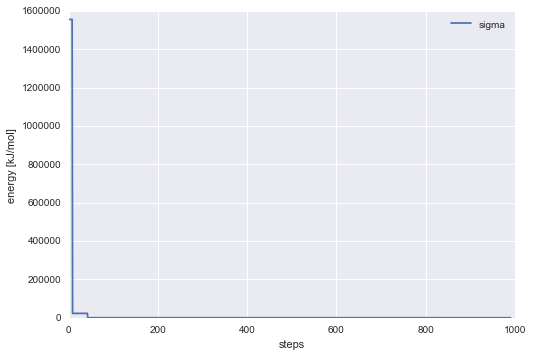

In [7]:
plt.plot(np.exp(sampler.trace('sigma')[9:]), label='sigma')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')

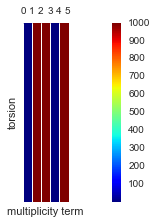

In [8]:
import torsionfit.plots as plots
plots.marg_mult(toy.model, sampler, 10000, 0, 'random.png')


In [9]:
print('true value')
print(toy.true_value)
print('initial value')
print(toy.initial_value)

true value
<DihedralTypes [<DihedralType; phi_k=13.559, per=6, phase=0.000,  scee=1.000, scnb=1.000>]>
initial value
<DihedralTypes [<DihedralType; phi_k=19.132, per=4, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=10.657, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=16.162, per=6, phase=0.000,  scee=1.000, scnb=1.000>]>


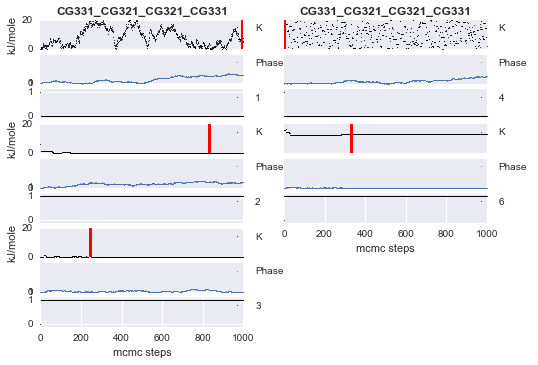

In [10]:
plots.trace_plots('CG331_CG321_CG321_CG331', sampler, markersize=2.0)

In [11]:
data = np.stack((sampler.CG331_CG321_CG321_CG331_1_K.trace[100:],
                sampler.CG331_CG321_CG321_CG331_2_K.trace[100:], sampler.CG331_CG321_CG321_CG331_3_K.trace[100:], 
                sampler.CG331_CG321_CG321_CG331_4_K.trace[100:], sampler.CG331_CG321_CG321_CG331_6_K.trace[100:]), axis=1)

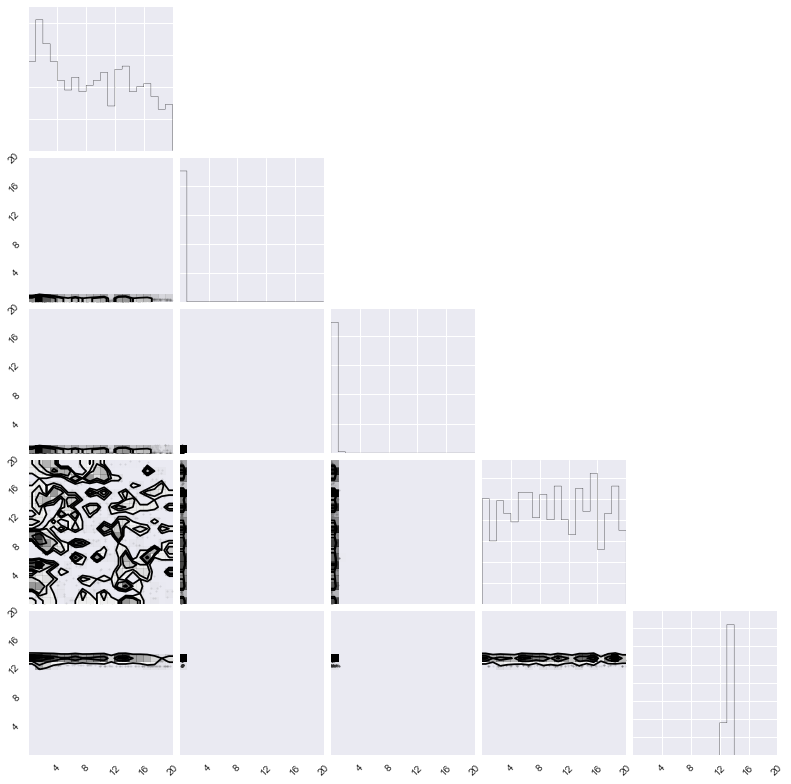

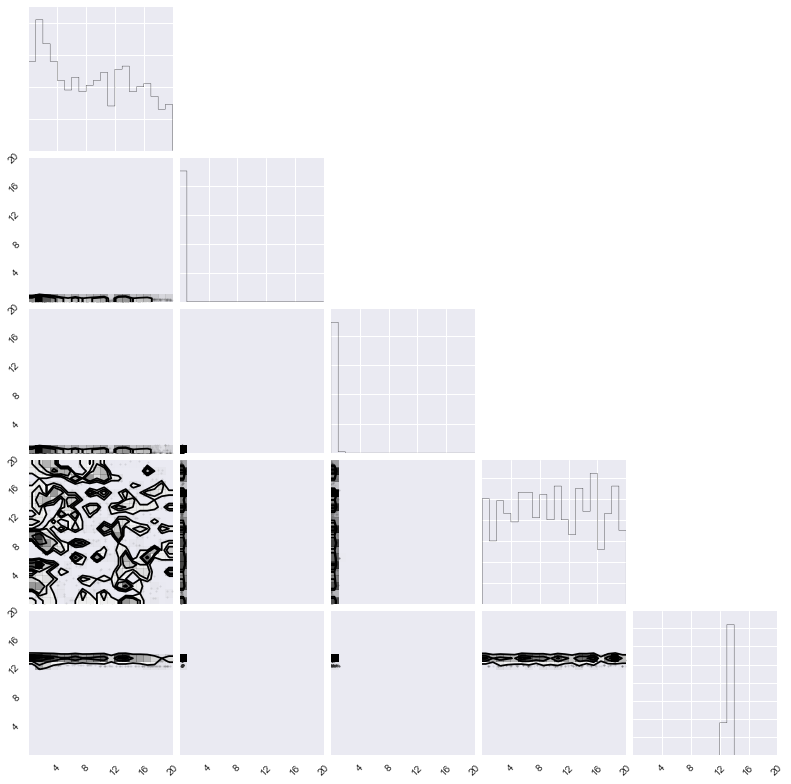

In [12]:
corner.corner(data, plot_countours=False, range=[(0, 20), (0,20), (0,20), (0,20), (0,20)])

In [13]:
data = np.stack((sampler.CG331_CG321_CG321_CG331_1_Phase.trace[100:],
                sampler.CG331_CG321_CG321_CG331_2_Phase.trace[100:], sampler.CG331_CG321_CG321_CG331_3_Phase.trace[100:], 
                sampler.CG331_CG321_CG321_CG331_4_Phase.trace[100:], sampler.CG331_CG321_CG321_CG331_6_Phase.trace[100:]), axis=1)

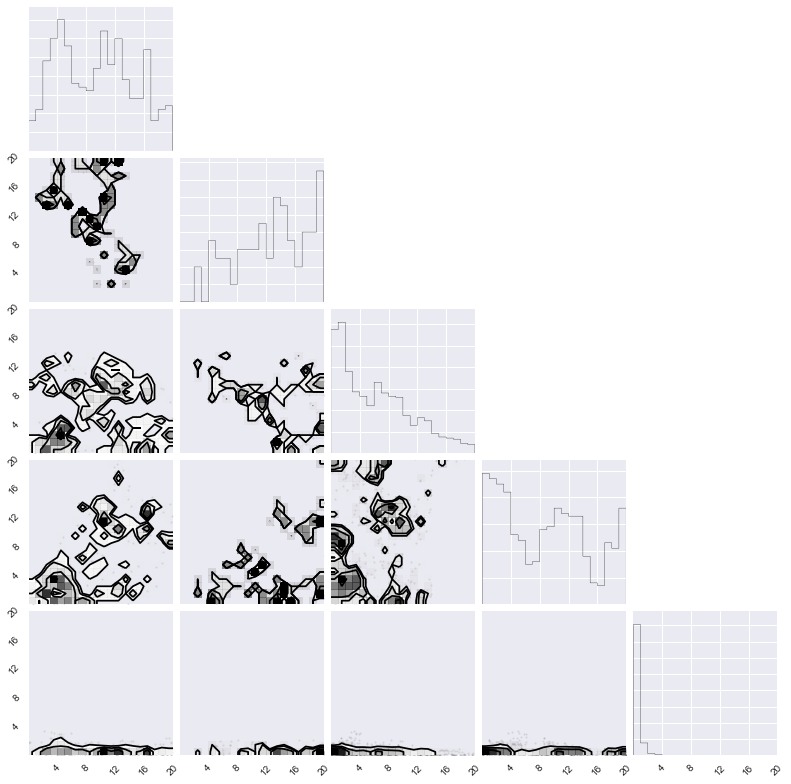

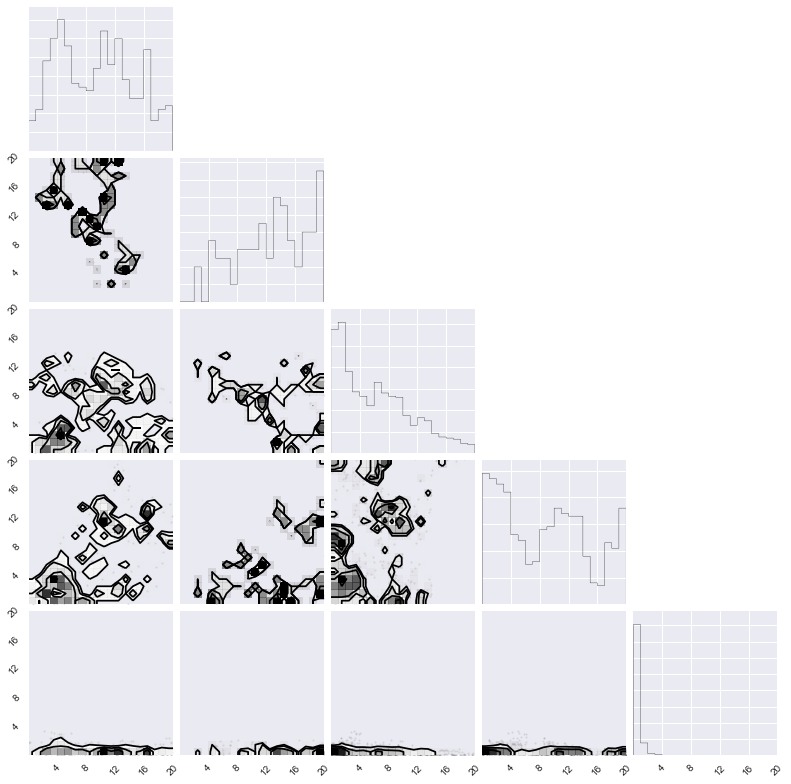

In [14]:
corner.corner(data, plot_countours=False, range=[(0, 20), (0,20), (0,20), (0,20), (0,20)])

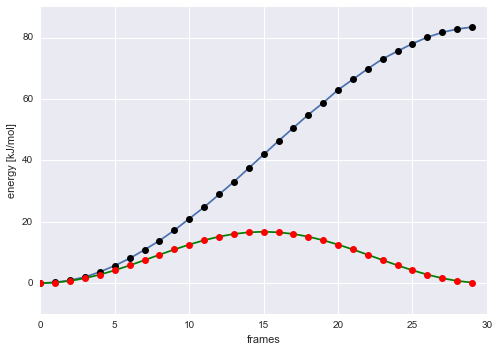

In [21]:
toy2 = ToyModel(true_value=DihedralType(10, 1, 180, 1, 1), initial_value=DihedralType(2, 2, 180, 1, 1), n_increments=30)
#toy = ToyModel(n_increments=50, decouple_n=True)
#toy.scan_set.save_initial_mm(toy._param)
plt.plot(toy2.synthetic_energy)
plt.plot(toy2.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.plot(toy2.scan_set.mm_energy, color='g')
plt.plot(toy2.scan_set.initial_mm, 'ko', color='r')

In [22]:
# sample
sampler2 = MCMC(toy2.model.pymc_parameters)
sampler2.sample(iter=1000)

 [-----------------100%-----------------] 1001 of 1000 complete in 35.3 sec

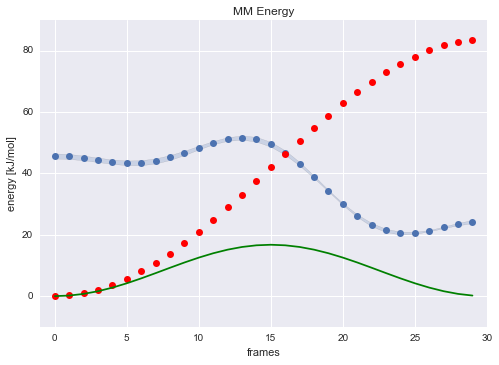

In [23]:
seaborn.tsplot(sampler2.trace('mm_energy')[:], interpolate=False)
plt.plot(toy2.synthetic_energy, 'o', color='r')
plt.title('MM Energy')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
#plt.plot(sampler.trace('mm_energy')[0])
plt.plot(toy2.scan_set.initial_mm, color='g')

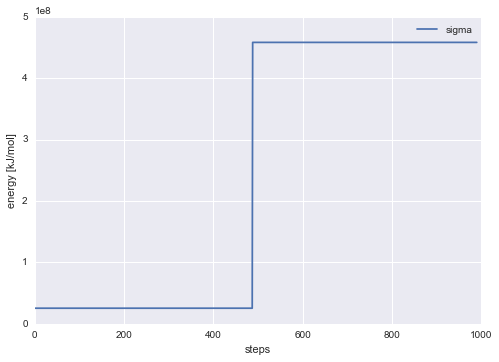

In [24]:
plt.plot(np.exp(sampler2.trace('sigma')[9:]), label='sigma')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')

import torsionfit.plots as plots
plots.marg_mult(toy.model, sampler, 10000, 0, 'random.png')

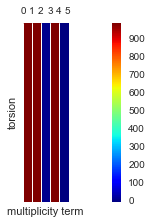

In [25]:
import torsionfit.plots as plots 
plots.marg_mult(toy2.model, sampler2, 10000, 0, 'random.png')

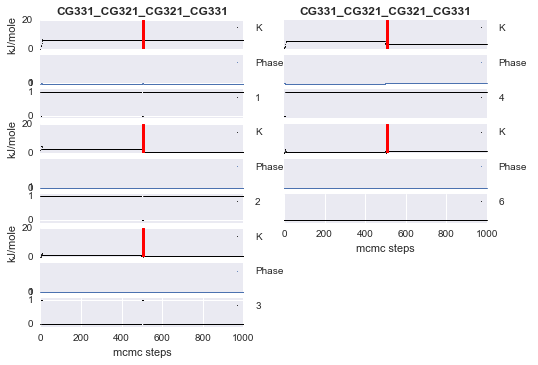

In [26]:
plots.trace_plots('CG331_CG321_CG321_CG331', sampler2, markersize=2.0)

In [27]:
data = np.stack((sampler2.CG331_CG321_CG321_CG331_1_K.trace[100:],
                sampler2.CG331_CG321_CG321_CG331_2_K.trace[100:], sampler2.CG331_CG321_CG321_CG331_3_K.trace[100:], 
                sampler2.CG331_CG321_CG321_CG331_4_K.trace[100:], sampler2.CG331_CG321_CG321_CG331_6_K.trace[100:]), axis=1)

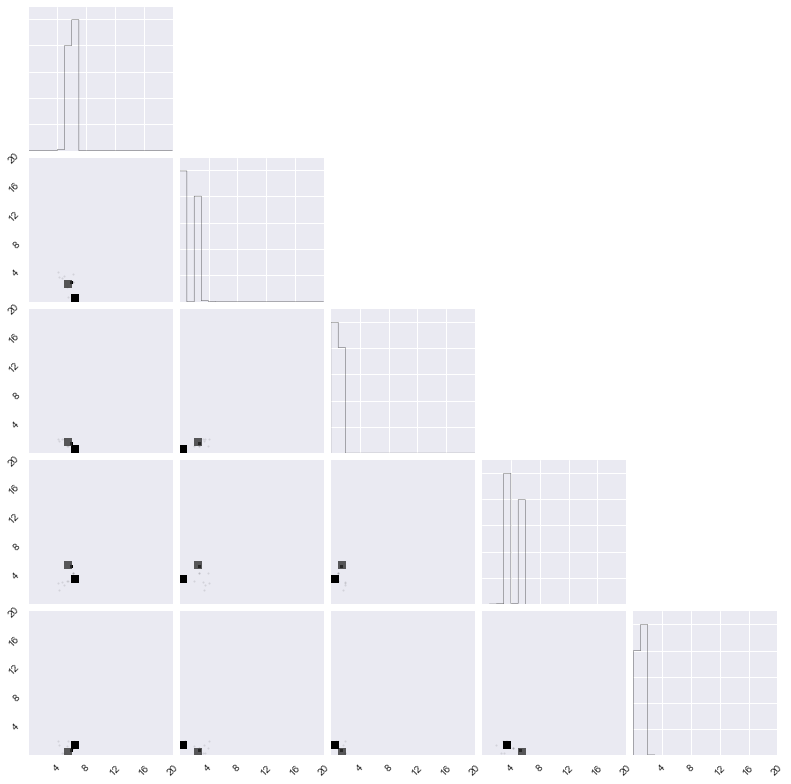

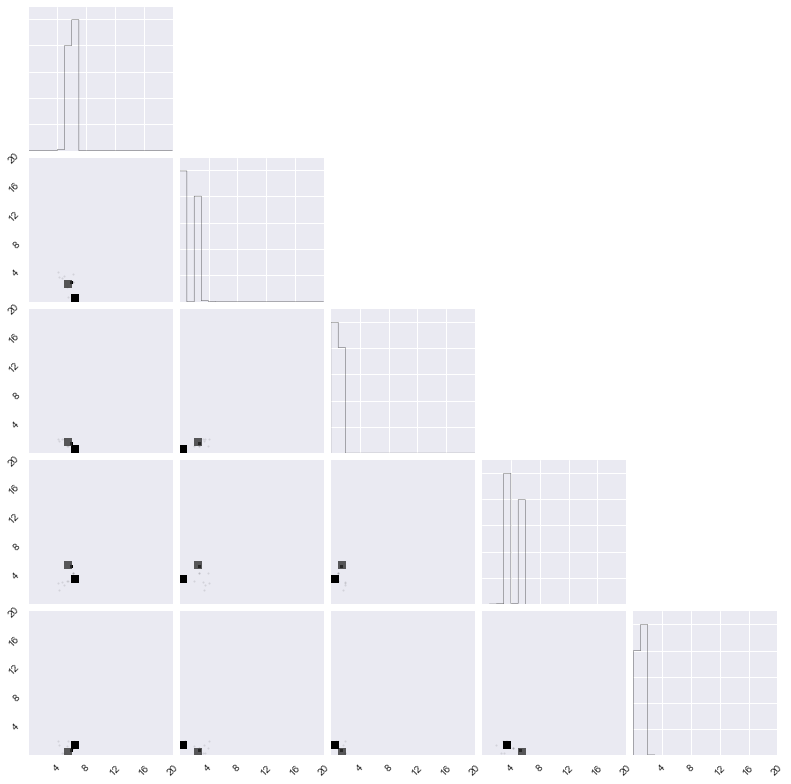

In [28]:
corner.corner(data, plot_countours=False, range=[(0, 20), (0,20), (0,20), (0,20), (0,20)])